# Choosing the number of nucleotides in the bag of words for Transformers

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['agg.path.chunksize'] = 0
mpl.rcParams.update( mpl.rc_params() )
plt.rcParams.update({'font.size': 18})
#plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': 'bold'})
plt.rc('font', family='serif')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import keras
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from sklearn.metrics import r2_score

import statistics


2022-12-08 19:38:53.424691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Useful Functions

In [41]:
def split_atg(X1,X,y):
    label_atg,atg,label_no_atg,no_atg = [], [], [], []
    for i in range(len(X)):
        seq = ""
        for j in range(len(X[1])-1):
            seq += X[i][j][0]
        seq += X[i][-1]
        if "ATG" in seq:
            atg.append(X1[i])
            label_atg.append(y[i])
        else:
            no_atg.append(X1[i])
            label_no_atg.append(y[i])
    return np.array(label_atg),np.array(atg),np.array(label_no_atg),np.array(no_atg) 
    

def split_seq_into_words(n, seqs):
    return np.array([" ".join([str(seqs[i][j:j+n]) for j in range(0,len(seqs[i])-n+1)]) for i in range(len(seqs))])
    

def r2(x,y):
    return 1 - sum((x-y)**2)/sum((x-np.mean(x))**2)
        
def inverse_scale(dist, scaled):
    s = statistics.stdev(rl)
    m = np.mean(rl)
    return s*scaled+m
    

## Importing the data

In [42]:
data_path = "Data/GSM3130435_egfp_unmod_1_PREPROCESSED.csv.gz"
df = pd.read_csv(data_path, compression='gzip')


In [43]:
df.head()

,Unnamed: 0,utr,0,1,2,3,4,5,6,7,...,r9,r10,r11,r12,r13,rl,Selection,one-hot encoding,Length,scaled_rl
0,120605,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCG...,0.000137,0.000109,0.000057,0.000033,0.000015,0.000016,0.000009,0.000009,...,0.019283,0.033252,0.033252,0.027581,0.035877,3.039939,Selected Data,"[[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",50,-2.130922
1,11605,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTA...,0.000067,0.000070,0.000065,0.000048,0.000023,0.000020,0.000011,0.000011,...,0.024241,0.039457,0.039457,0.039840,0.038785,3.895109,Selected Data,"[[0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,...",50,-1.600332
2,128224,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGAC...,0.000088,0.000081,0.000059,0.000035,0.000017,0.000016,0.000009,0.000009,...,0.021591,0.028353,0.028353,0.028963,0.041985,3.334524,Selected Data,"[[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",50,-1.948147
3,239107,CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGT...,0.000078,0.000071,0.000060,0.000038,0.000025,0.000016,0.000010,0.000009,...,0.026617,0.038302,0.038302,0.032788,0.031043,3.575082,Selected Data,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",50,-1.798893
4,59082,GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTC...,0.000044,0.000045,0.000050,0.000051,0.000033,0.000026,0.000015,0.000012,...,0.033080,0.051449,0.051449,0.046052,0.036447,4.593712,Selected Data,"[[0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,...",50,-1.166885


In [44]:
rl = df["rl"].values
utr = df["utr"].values

## Building the model

This implementation included code from: https://www.kaggle.com/code/quadeer15sh/transformers-for-text-classification/notebook

In [45]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.forward = Sequential([layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),])
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)
        self.layernormalization1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernormalization2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, training):
        att_out = self.attention(inputs, inputs)
        att_out = self.dropout1(att_out, training=training)
        output1 = self.layernormalization1(inputs + att_out)
        fwd_output = self.forward(output1)
        fwd_output = self.dropout2(fwd_output, training=training)
        return self.layernormalization2(output1 + fwd_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_embedding = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_embedding = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        pos = tf.range(start=0, limit=maxlen, delta=1)
        pos = self.pos_embedding(pos)
        x = self.token_embedding(x)
        return x + pos


## Iterations where we vary the number of letters in the bag of words for the Transformer model

50
Vocab Size:  5
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 token_and_position_embeddin  (None, 50, 50)           2750      
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_encoder_2 (Tran  (None, 50, 50)           206532    
 sformerEncoder)                                                 
                                                                 
 rnn_2 (RNN)                 (None, 46)                17848     
                                                                 
 dense_10 (Dense)            (None, 46)                2162      
                                         

INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_1/assets


INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_1/assets


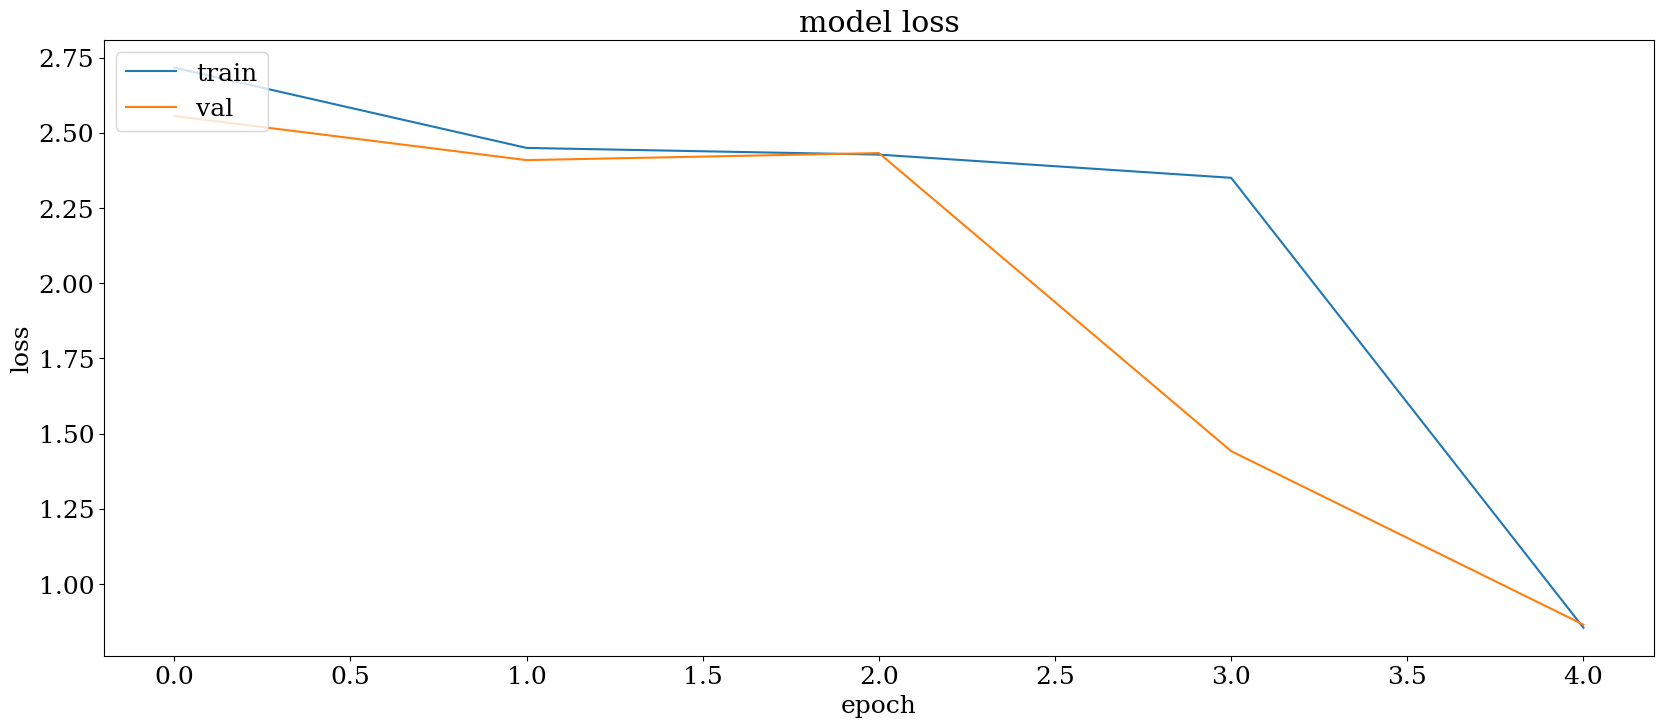

875/875 [==============================] - 407s 465ms/step
49
Vocab Size:  17
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 49)]              0         
                                                                 
 token_and_position_embeddin  (None, 49, 50)           3300      
 g_3 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_encoder_3 (Tran  (None, 49, 50)           206532    
 sformerEncoder)                                                 
                                                                 
 rnn_3 (RNN)                 (None, 46)                17848     
                                                                 
 dense_14 (Dense)            (None, 46)        

INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_2/assets


INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_2/assets


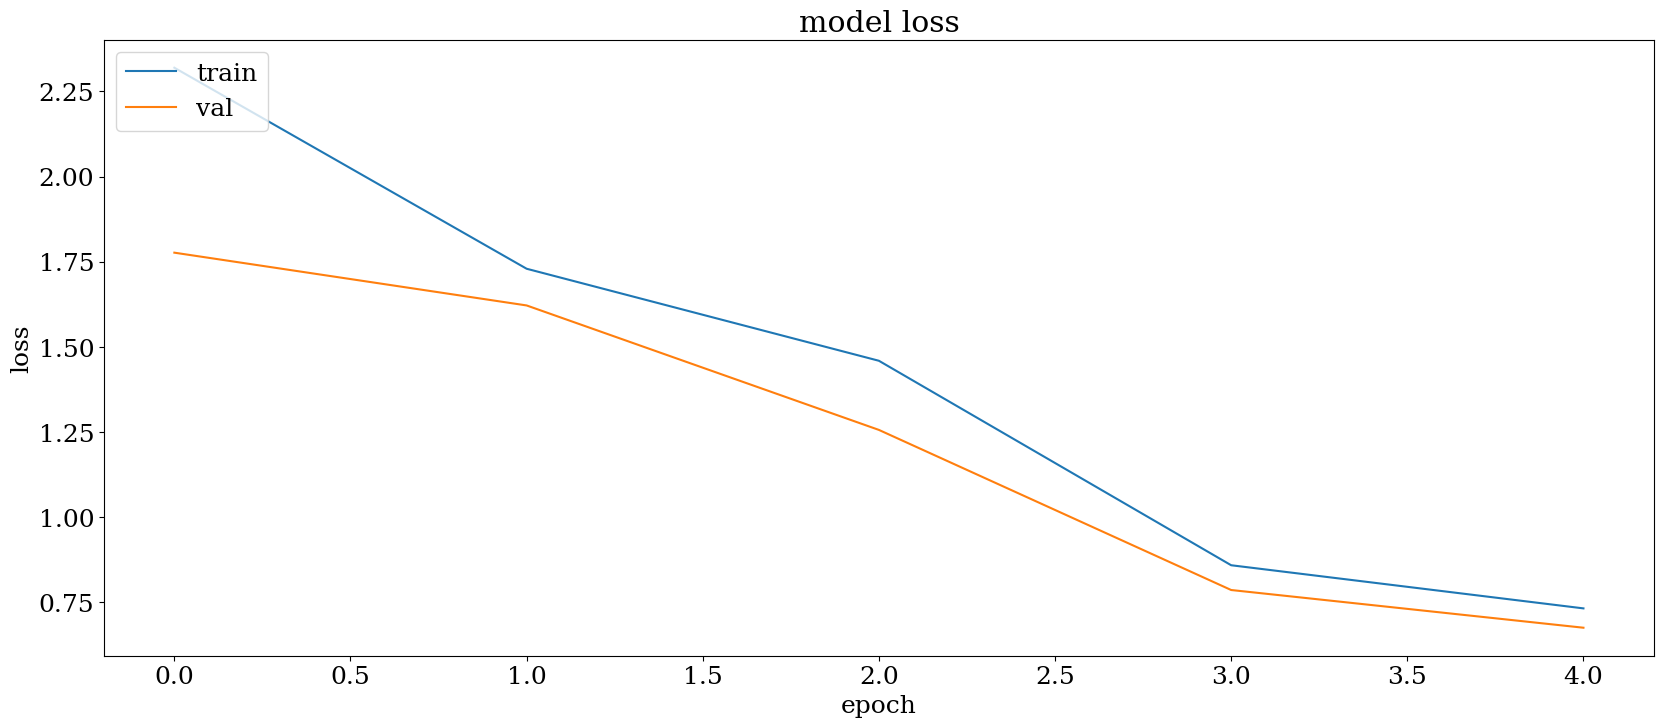

875/875 [==============================] - 99s 113ms/step
48
Vocab Size:  65
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 48)]              0         
                                                                 
 token_and_position_embeddin  (None, 48, 50)           5650      
 g_4 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_encoder_4 (Tran  (None, 48, 50)           206532    
 sformerEncoder)                                                 
                                                                 
 rnn_4 (RNN)                 (None, 46)                17848     
                                                                 
 dense_18 (Dense)            (None, 46)         

INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_3/assets


INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_3/assets


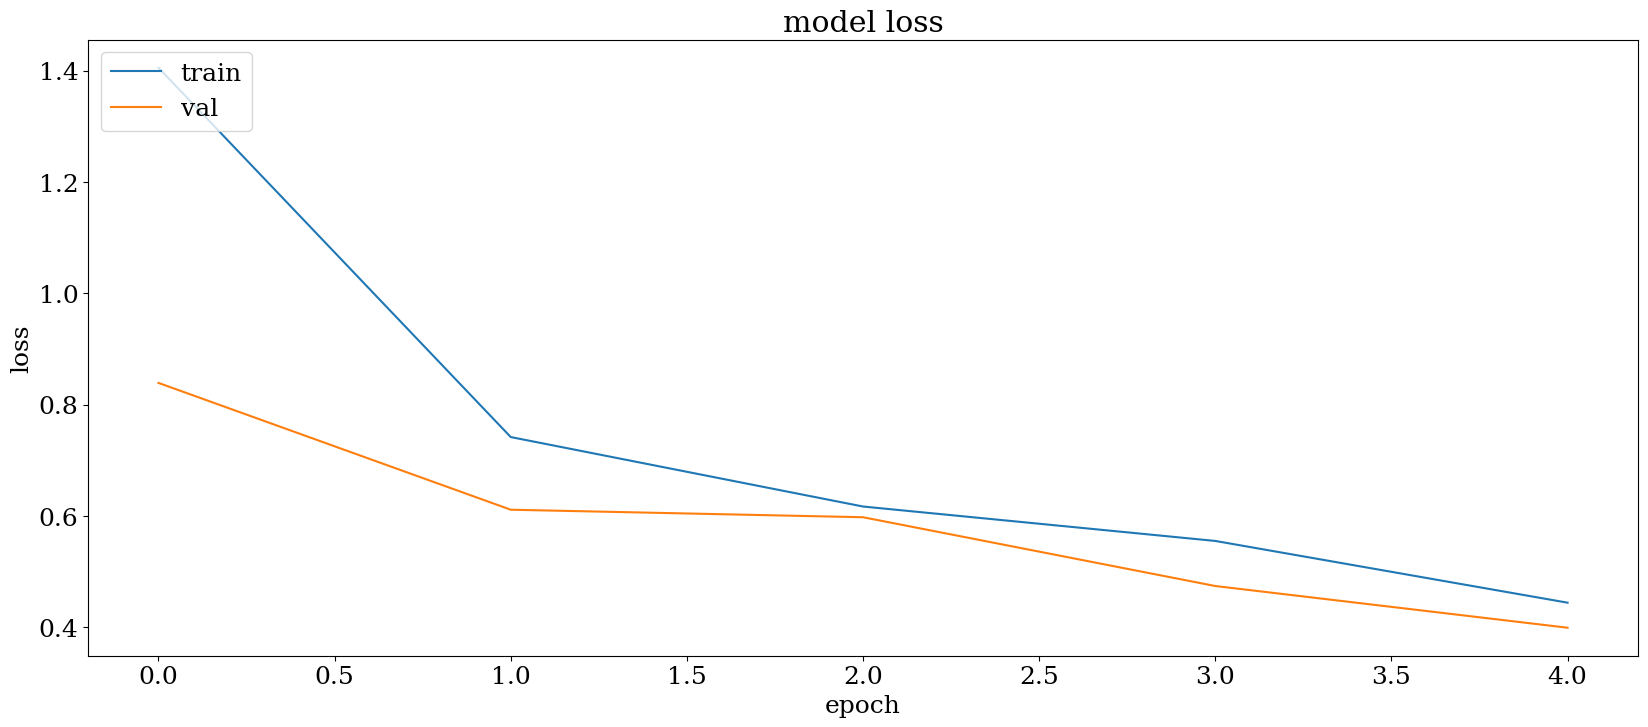

875/875 [==============================] - 97s 110ms/step
47
Vocab Size:  257
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 47)]              0         
                                                                 
 token_and_position_embeddin  (None, 47, 50)           15200     
 g_5 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_encoder_5 (Tran  (None, 47, 50)           206532    
 sformerEncoder)                                                 
                                                                 
 rnn_5 (RNN)                 (None, 46)                17848     
                                                                 
 dense_22 (Dense)            (None, 46)        

INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_4/assets


INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_4/assets


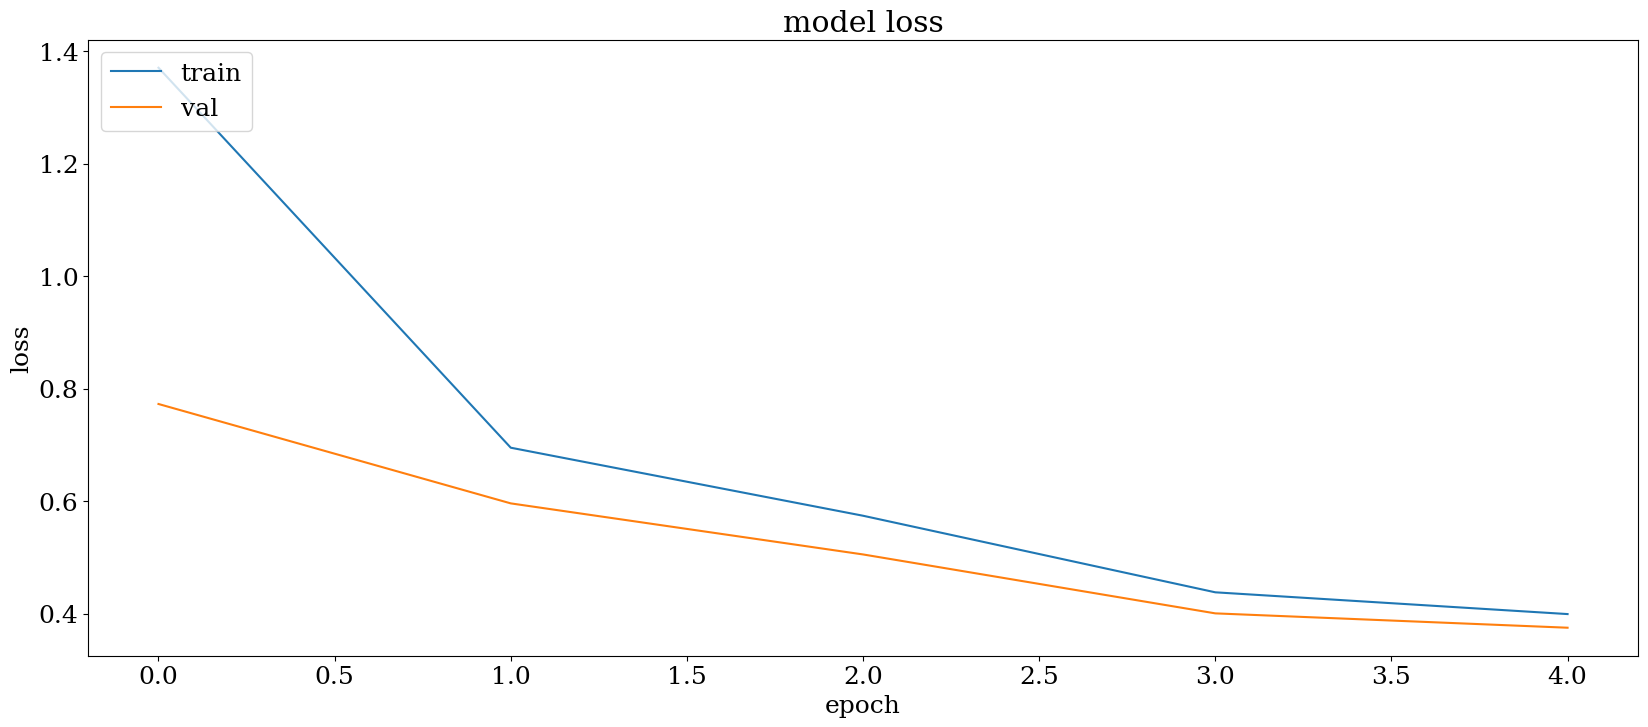

875/875 [==============================] - 95s 109ms/step
46
Vocab Size:  1025
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 46)]              0         
                                                                 
 token_and_position_embeddin  (None, 46, 50)           53550     
 g_6 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_encoder_6 (Tran  (None, 46, 50)           206532    
 sformerEncoder)                                                 
                                                                 
 rnn_6 (RNN)                 (None, 46)                17848     
                                                                 
 dense_26 (Dense)            (None, 46)       

INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_5/assets


INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_5/assets


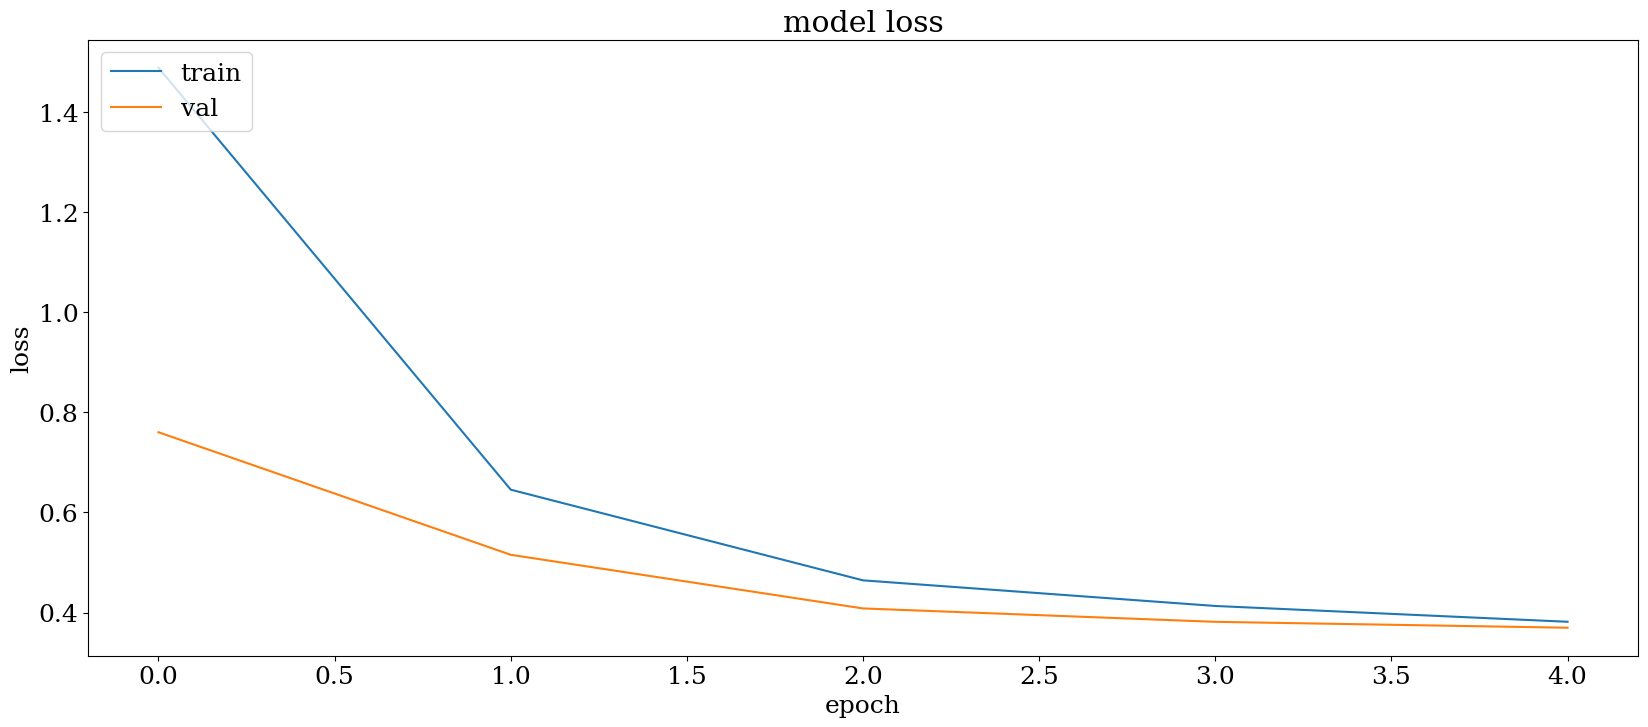

875/875 [==============================] - 138s 157ms/step
45
Vocab Size:  4097
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 45)]              0         
                                                                 
 token_and_position_embeddin  (None, 45, 50)           207100    
 g_7 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_encoder_7 (Tran  (None, 45, 50)           206532    
 sformerEncoder)                                                 
                                                                 
 rnn_7 (RNN)                 (None, 46)                17848     
                                                                 
 dense_30 (Dense)            (None, 46)      

INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_6/assets


INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_6/assets


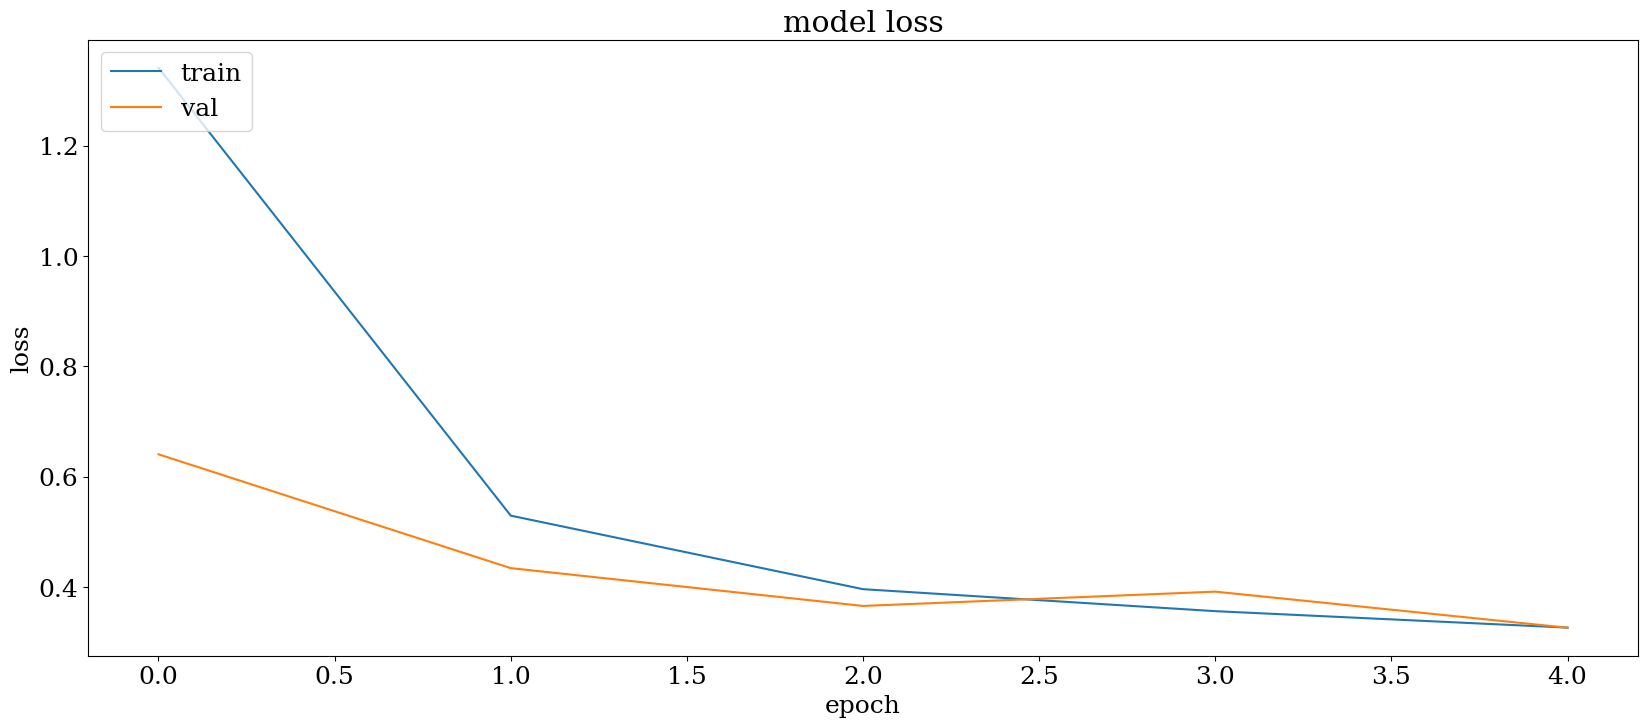

875/875 [==============================] - 140s 160ms/step
44
Vocab Size:  16385
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 44)]              0         
                                                                 
 token_and_position_embeddin  (None, 44, 50)           821450    
 g_8 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_encoder_8 (Tran  (None, 44, 50)           206532    
 sformerEncoder)                                                 
                                                                 
 rnn_8 (RNN)                 (None, 46)                17848     
                                                                 
 dense_34 (Dense)            (None, 46)     

INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_7/assets


INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_7/assets


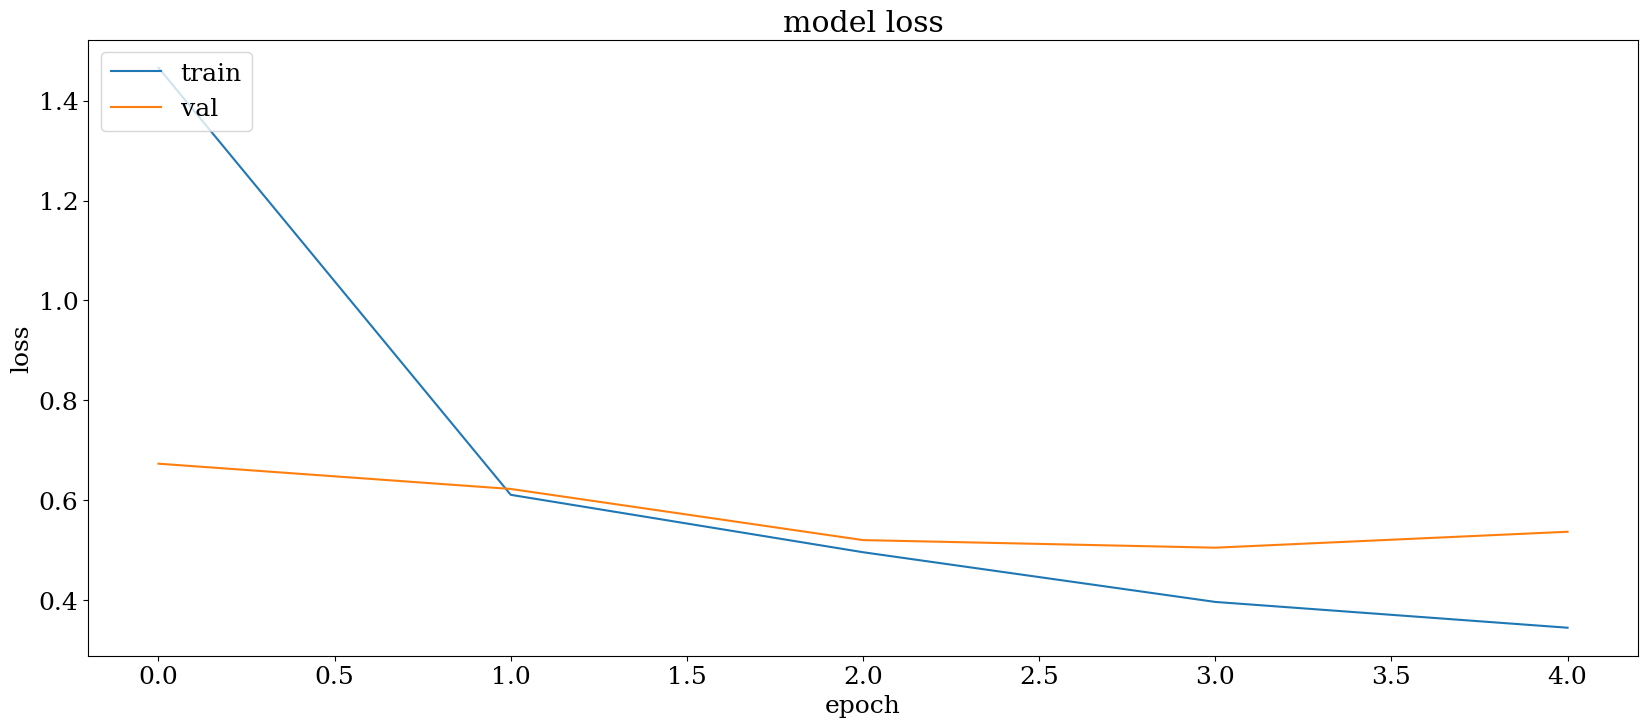

875/875 [==============================] - 88s 101ms/step
43
Vocab Size:  65537
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 43)]              0         
                                                                 
 token_and_position_embeddin  (None, 43, 50)           3279000   
 g_9 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_encoder_9 (Tran  (None, 43, 50)           206532    
 sformerEncoder)                                                 
                                                                 
 rnn_9 (RNN)                 (None, 46)                17848     
                                                                 
 dense_38 (Dense)            (None, 46)      

INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_8/assets


INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_8/assets


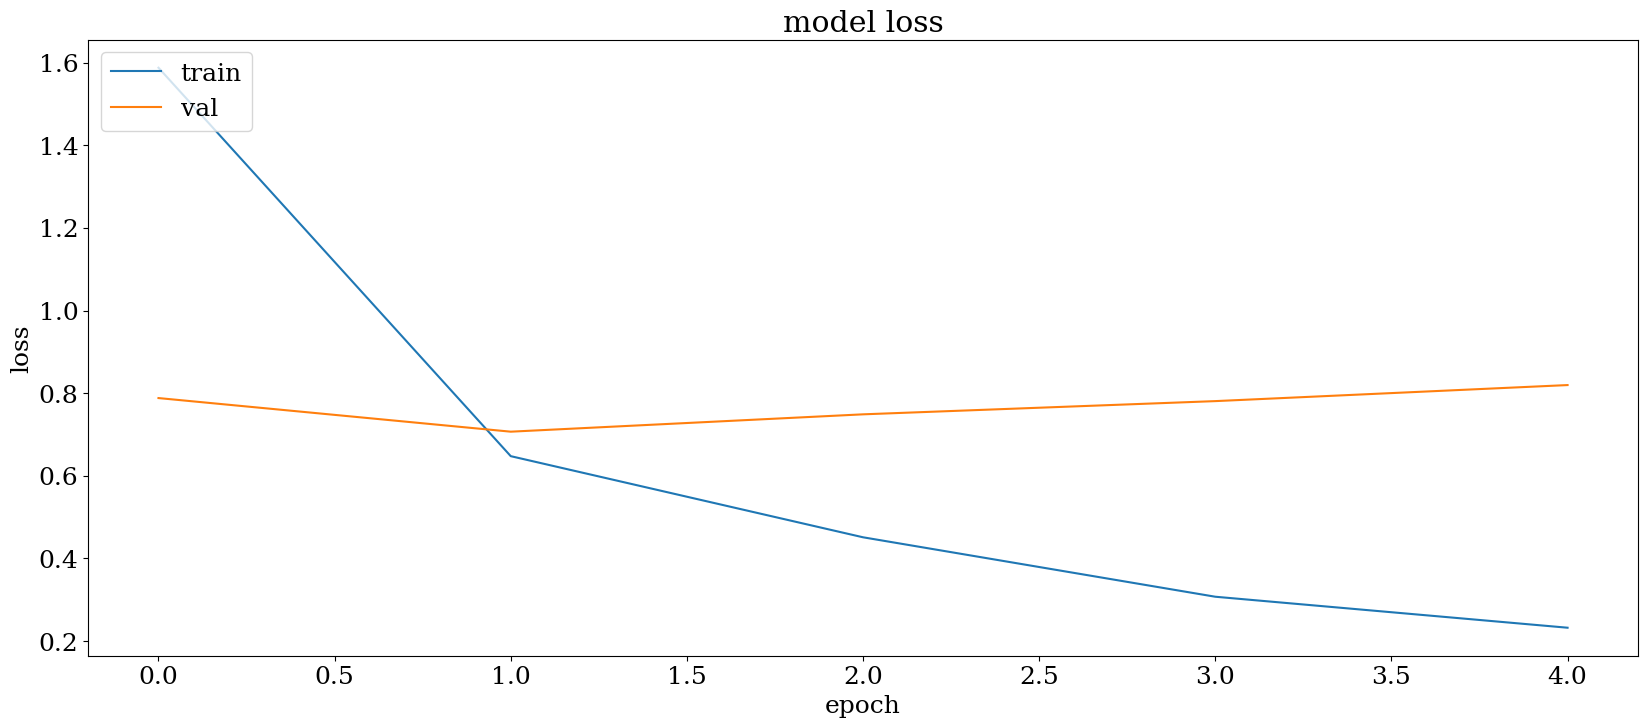

875/875 [==============================] - 143s 164ms/step
42
Vocab Size:  262145
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 42)]              0         
                                                                 
 token_and_position_embeddin  (None, 42, 50)           13109350  
 g_10 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_encoder_10 (Tra  (None, 42, 50)           206532    
 nsformerEncoder)                                                
                                                                 
 rnn_10 (RNN)                (None, 46)                17848     
                                                                 
 dense_42 (Dense)            (None, 46)   

INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_9/assets


INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_9/assets


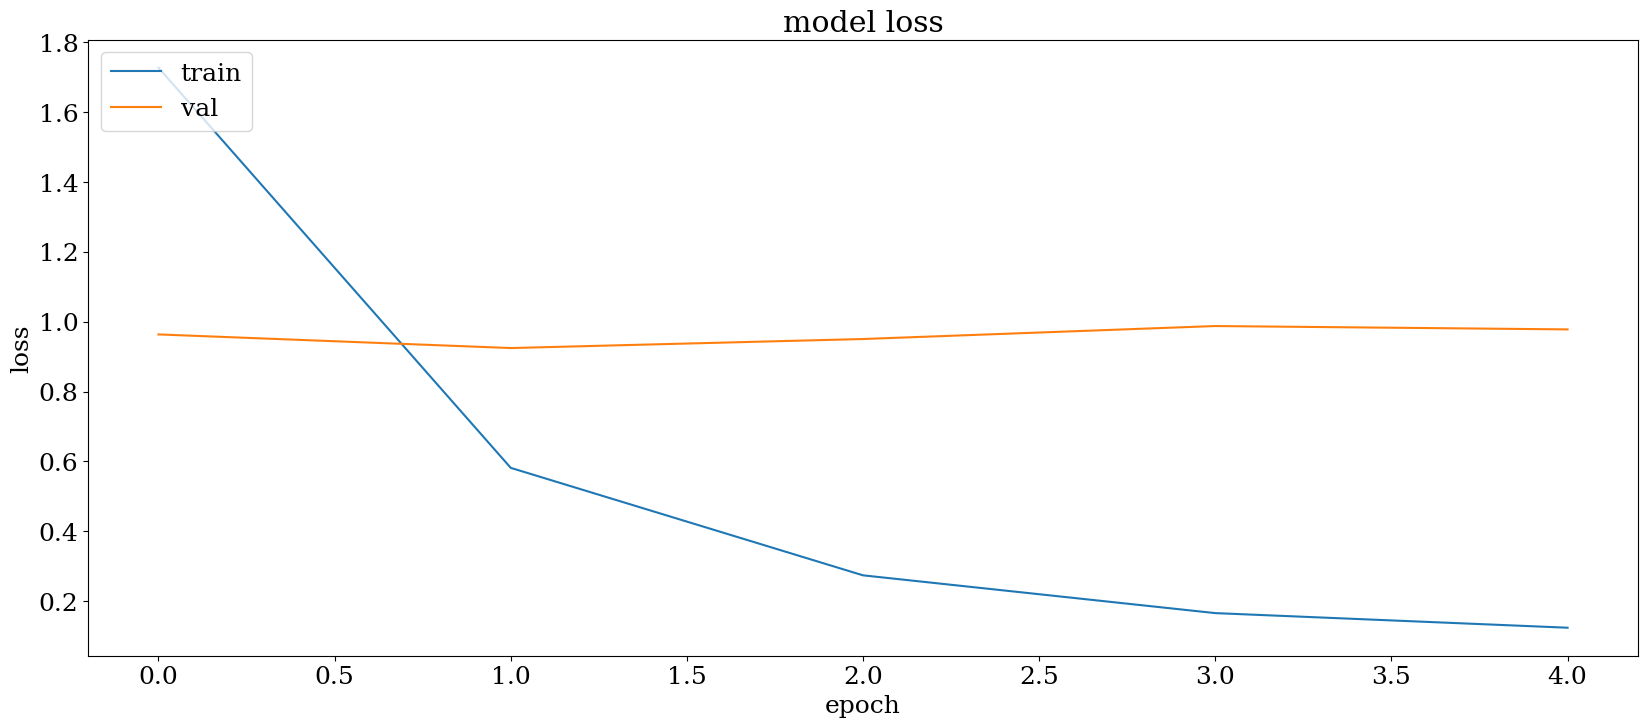

875/875 [==============================] - 93s 106ms/step
41
Vocab Size:  1043310
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 41)]              0         
                                                                 
 token_and_position_embeddin  (None, 41, 50)           52167550  
 g_11 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_encoder_11 (Tra  (None, 41, 50)           206532    
 nsformerEncoder)                                                
                                                                 
 rnn_11 (RNN)                (None, 46)                17848     
                                                                 
 dense_46 (Dense)            (None, 46)   

INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_10/assets


INFO:tensorflow:Assets written to: model_transformer_mrl_fit_different_word_length_10/assets


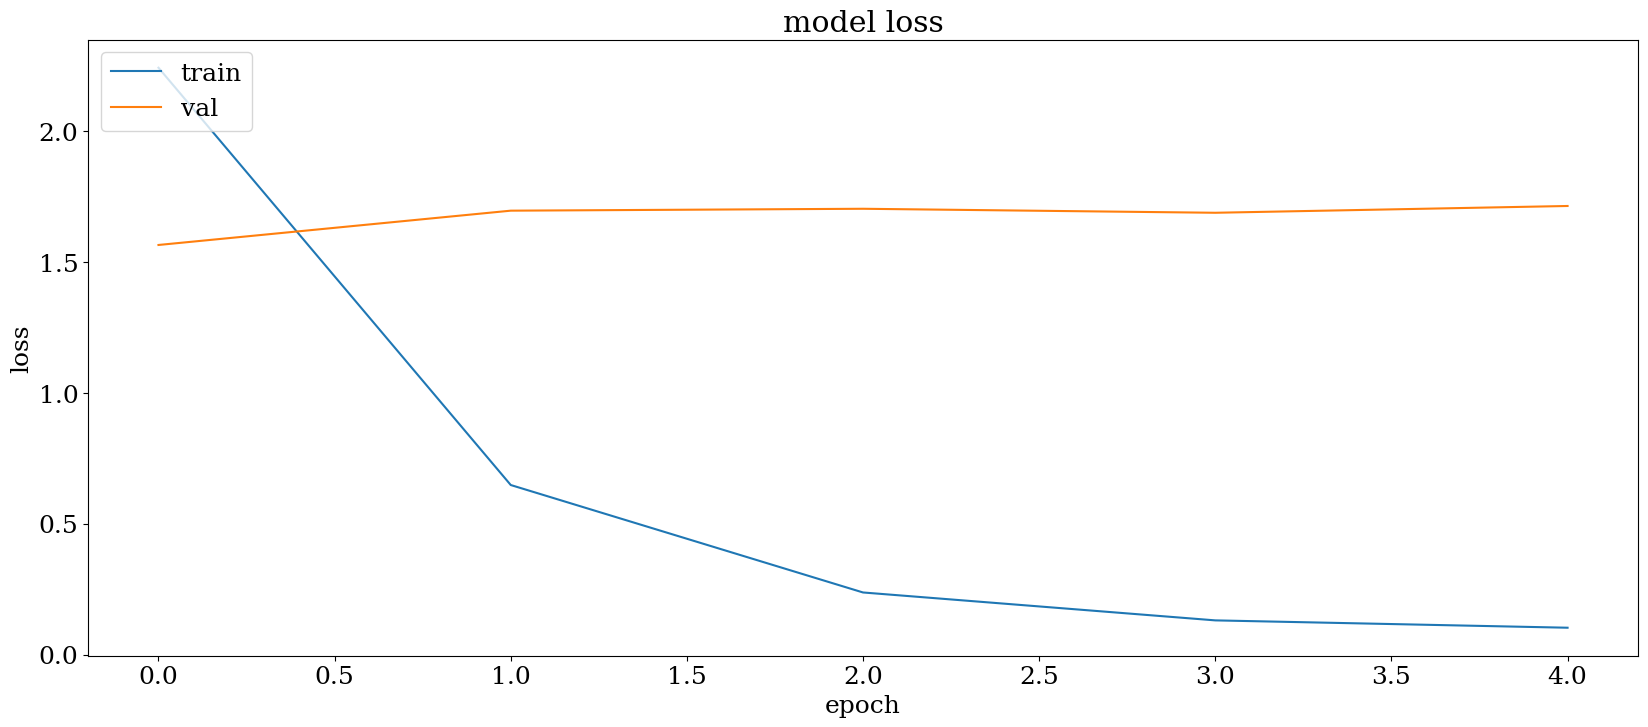

875/875 [==============================] - 91s 103ms/step


In [46]:
r2_diff_length = []

for i in range(1,11):
    #Splitting the data into training, validation and test sets
    sentences = split_seq_into_words(i, utr)
    X_train, X_val, y_train, y_val = train_test_split(sentences, rl, test_size=0.2, random_state=25)
    X_val, X_test1, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=25)
    
    #Tokenization
    max_len = (len(sentences[0])+1)//(i+1)
    print(max_len)
    oov_token = '00_V' 
    padding_type = 'post'
    trunc_type = 'post'  

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    vocab_size = len(tokenizer.word_index) + 1
    print("Vocab Size: ",vocab_size)
    
    train_temp = tokenizer.texts_to_sequences(X_train)
    X_train = pad_sequences(train_temp, maxlen=max_len, padding=padding_type, truncating=trunc_type)

    val_temp = tokenizer.texts_to_sequences(X_val)
    X_val = pad_sequences(val_temp, maxlen=max_len, padding=padding_type, truncating=trunc_type)

    test_temp = tokenizer.texts_to_sequences(X_test)
    X_test = pad_sequences(test_temp, maxlen=max_len, padding=padding_type, truncating=trunc_type)
    
    #Training the model
    embed_dim = 50
    heads = 20
    neurons = 32
    units=46

    inputs = layers.Input(shape=(max_len,))
    embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerEncoder(embed_dim, heads, neurons)
    x = transformer_block(x)
    x = keras.layers.RNN(keras.layers.LSTMCell(units), input_shape=(max_len,))(x)
    x = layers.Dense(46, activation="relu")(x)
    outputs = layers.Dense(1, activation="linear")(x)
    model = Model(inputs=inputs, outputs=outputs)
    adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=[r2_score], run_eagerly=True)
    model.summary()
    model_name = "model.h5"
    checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, 
                                                min_lr=0.00000001)
    history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=5,
                    batch_size=128)
    
    #Saving the model
    model.save('model_transformer_mrl_fit_different_word_length_'+str(i))
    
    plt.figure(figsize=(20,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    #Testing the model and recording the r^2 value
    predictions = model.predict(X_test).reshape(-1)
    r_val = r2(y_test, predictions)
    r2_diff_length.append(r_val)

## Results

In [6]:
r2_diff_length

[0.6696948964558134,
 0.7366434406258442,
 0.8420909919274457,
 0.85232281494003,
 0.8547194211078382,
 0.8703772568393479,
 0.7957558089267524,
 0.6903001062222992,
 0.6264947270666921,
 0.3548838205193605]

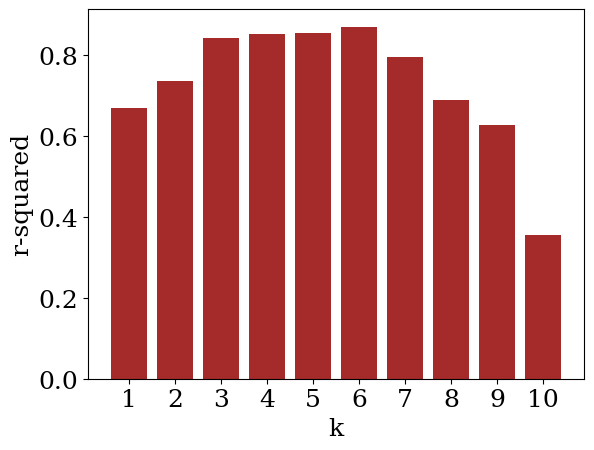

In [5]:
plt.bar([i for i in range(1, 11)], r2_diff_length, color = "brown")
plt.xlabel("k")
plt.ylabel("r-squared")
plt.xticks([i for i in range(1, 11)])
plt.savefig("rsquaredk.pdf", bbox_inches = "tight")
plt.show()

## Testing model 1: Using one letter windows

In [53]:
model = keras.models.load_model('model_transformer_mrl_fit_different_word_length_1', 
                                custom_objects = {"r2_score":r2_score})


In [54]:
i =1
sentences = split_seq_into_words(i, utr)
X_train, X_val, y_train, y_val = train_test_split(sentences, rl, test_size=0.2, random_state=25)
X_val, X_test1, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=25)
max_len = (len(sentences[0])+1)//(i+1)
print(max_len)
oov_token = '00_V' 
padding_type = 'post'
trunc_type = 'post'  

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

train_temp = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_temp, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_temp = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_temp, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_temp = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_temp, maxlen=max_len, padding=padding_type, truncating=trunc_type)

50
Vocab Size:  5


In [55]:
predictions = model.predict(X_test).reshape(-1)
r_val = r2(y_test, predictions)
r_val


875/875 [==============================] - 48s 55ms/step


0.6696948977833298